**Máster Interuniversitario en Tecnologías de Análisis de Datos Masivos: Big Data**  
**Tecnologías de Gestión de Información no Estructurada**  
**PRÁCTICA 4: Clasificador de tweets**  
*Juan Adan Estrada Toledano*  

En esta práctica extraeremos contenidos de Twitter, procesaremos los tweets extraidos y realizaremos experimentos básicos de clasificación y análisis de sentimientos.

##Twitter

Twitter es actualmente una dinámica e ingente fuente de contenidos que, dada su popularidad e impacto, generá enorme interés para realizar distintos estudios de Social Media Analytics. Análisis de reputación de empresas, productos o personalidades, estudios de impacto relacionados con el marketing, extracción de opiniones y predicción de tendencias son sólo algunos ejemplos de aplicaciones que en los últimos años han venido utilizando Twitter como fuente de referencia.

Nota importante: hay límites de la frecuencia en el uso de la API de Twitter, así como limitaciones en caso de que quiera descargar un conjunto de datos, ver:

  * https://dev.twitter.com/overview/terms/agreement-and-policy
  * https://dev.twitter.com/rest/public/rate-limiting
  
## P4ClaTweJAET.py
Es un script python que extrae contenidos de dos perfiles en Twitter, se procesan los tweets extraidos y se realiza experimentos básicos de clasificación y análisis de sentimentos.
###Ejemplos de ejecución.

  * Extraer 2200 tweets de dos figuras en camapaña politica en USA para las elecciones 2016, genera y compara modelos de clasificación también compara la polaridad de tweets de ambos políticos: **P4ClaTweJAET.py -t1 hillaryclinton -t2 realdonaldtrump -t 2200**
  * Extraer 2800 tweets de dos figuras politicas en USA, una en camapaña y la segunda ejerciendo su cargo. Se compara el comportamiento: **P4ClaTweJAET.py -t1 BarackObama -t2 realdonaldtrump -t 2800**
  
En el primer ejemplo, se eligió 2200 porque para el perfil *hillaryclinton* es el maximo que regresa aunque se le hagan peticiones adicionales. Para el caso de *realdonaldtrump* el máximo permisible fue de 2800, de ahí los valores. Los 4 archivos van incluidos en el directorio de éste *IPnotebook* para saltar la extracción.
  
### Valores
Valores por defecto: *-t1 BarackObama -t2 realdonaldtrump -t 2800*. Donde: *[-t1 TARGET1] [-t2 TARGET2] [-t TWEETS]*
  
###Código

Definir los argumentos que acepta el programa, valores predeterminados e importaciones requeridas.

In [91]:
"""
Created on Sat Nov 28 12:42:58 2015

@author: adane_000
"""
import tweepy
import os.path
import pickle
import time
import authTweepy as at
import re
import sys
WINDOW_RATE_MIN = 16
SLEEP_TIME_SEC = 60
TWEETS_EXTRACT = 2800
targets = {}
targets['t1'] = {}
targets['t1']["id"] = "BarackObama"
targets['t1']["nameFile"] = targets['t1']["id"] + str(TWEETS_EXTRACT) + '.pickle'
targets['t2'] = {}
targets['t2']["id"] = "realdonaldtrump"
targets['t2']["nameFile"] = targets['t2']["id"] + str(TWEETS_EXTRACT) + '.pickle'

A partir de una cuenta de Twitter, tenemos que crear una “Twitter App”. Una Twitter App es esencialmente un mecanismo que proporciona Twitter para desarrolladores que quieran acceder a los contenidos de Twitter a través de programas. Al crear una Twitter App, Twitter nos proporciona una serie de claves que son las que tenemos que usar en el programa.

In [92]:
import authTweepy as at
auth = tweepy.OAuthHandler(at.consumer_key, at.consumer_secret)
auth.set_access_token(at.access_token, at.access_token_secret)
# Get the User object for twitter...
api = tweepy.API(auth)


###Acceso a los Datos
Twitter ofrece APIs REST que se puede utilizar para interactuar con su servicio. También hay un montón de clientes basados en Python por ahí que podemos utilizar sin necesidad de volver a inventar la rueda. En particular, Tweepy en una de las más interesantes y fáciles de usar, así que es la elegida para la extracción.
Para autorizar nuestra aplicación para acceder a Twitter, tenemos que utilizar la interfaz de OAuth: y presentar las credenciales correspondientes y respetar los limites de solicitud de tweets. Tweepy ofrece la cómoda interfaz de Cursor para recorrer los diferentes tipos de objetos. Por ejemplo se puede limitar elnúmero de tweets que estamos leyendo a aprtir de un objeto iterable, un bonito envoltorio para acceder a los datos. La respuesta JSON de la API Twitter está disponible en el \_json atributo (con un subrayado inicial), que no es la cadena JSON crudo, sino un diccionario.  
Hay diferentes tipos de datos que podemos recoger, con el foco obvio en el objeto "tweet". Una vez que hemos recopilado algunos datos, las posibilidades en términos de análisis de aplicaciones son infinitas. Más adelante, vamos a discutir algunas opciones.  La estructura de un tweet tiene muchas carácteristicas disponibles, sin embargo, los atributos que almacenamos en este caso son:  

  * text: el texto del propio tweet
  * created_at: fecha de creación
  * id: el identificador del tweet
  
En esta práctica, se elijio guardar los tweets en un archivo binario de tipo pickle.

In [93]:
def getDateString(dt):
    """Obtener el string de un datetime para la fecha de creacion del tweet"""
    stringDateTime = str(dt.date()) + ' ' + str(dt.time())
    return stringDateTime

def extractTweetsfromTarget(t):
    """Extraer tweets de la persona de interés"""
    dtweet = {}
    i = 0
    tweetsPerRequest = 200
    MaxIdTweet = tweepy.Cursor(api.user_timeline, id=t["id"],include_rts=False,exclude_replies=True).items(1).next().id
    rateLimit = False
    while TWEETS_EXTRACT > len(dtweet):
        for tweet in tweepy.Cursor(api.user_timeline, id=t["id"],max_id=MaxIdTweet, include_rts=False,exclude_replies=True).items(tweetsPerRequest):
            dtweet[i] = {}
            dtweet[i]['ID'] = tweet.id
            dtweet[i]['text'] = tweet.text #.encode('utf-8')
            dtweet[i]['created_at'] = getDateString(tweet.created_at)
            i = i + 1
        MaxIdTweet = dtweet[i-1]['ID']
        MaxIdTweet = MaxIdTweet - 1
        print("   Sleep: ", str(len(dtweet)), " / ", str(TWEETS_EXTRACT))
        if(len(dtweet) >= 2600 and rateLimit == False ):
            print("   Sleep 15 min:")
            rateLimit = True
            minute = 0
            while minute < WINDOW_RATE_MIN:
                sys.stdout.write('.')
                time.sleep(60)
                minute = minute + 1
        else:
            time.sleep(SLEEP_TIME_SEC)
    print("   Wake up...")
    #guardar la estructura de datos en binario
    dicStore = {k: dtweet[k] for k in range(0,TWEETS_EXTRACT)}
    pickle.dump(dicStore, open(t['nameFile'], 'wb'))
    print("   Se ha almacenado un archivo binario con los tweets de ", t["id"])

Con el objetivo de evitar extracción cada que se solicita una ejecución del programa, se valida si ya existe el fichero con los tweets del perfil en cuestión. En caso de no existir tal fichero, se procede a realizar la extracción. Una vez que se ha creado o cargado el fichero binario con los tweets de cada perfil, se realiza un preprocesamiento básico, que consiste en eliminar las URL's en el texto del tweet.   

*Nota: Dado que, se tienen que respetar los límites de solicitudes hacia twitter, el proceso de extracción podría demorar por los menos 15 minutos según el número de tweets solicitados*

In [94]:
"""*******Cargar o extraer tweets de cada figura**********************"""
keys_tar = ['t1','t2']
first = True
for key in keys_tar:
    target = targets[key]
    if os.path.isfile(target["nameFile"]):
        print("Reutilizar: " + target["nameFile"])
    else:
        print("Nueva extracción: " + target["nameFile"])
        extractTweetsfromTarget(target)
        minute = 0
        if first == True:
            first = False
            while minute < WINDOW_RATE_MIN:
                sys.stdout.write('.')
                time.sleep(60)
                minute = minute + 1
    target['tweetsDic'] = pickle.load(open(target["nameFile"], 'rb'))
    target['tweetsText'] = [target['tweetsDic'].get(k).get('text') for k in target['tweetsDic'].keys()]
    #**********Preprocesamiento Eliminar URL's *******************
    target['tweetsText'] = [re.sub(r"http\S+", "", tweet) for tweet in target['tweetsText']]



Reutilizar: BarackObama2800.pickle
Reutilizar: realdonaldtrump2800.pickle


###Entrenamiento y prueba
Una vez con los tweets disponibles, se unen los tweets de ambos perfiles y se procede a segmentar en dos conjuntos, el de entrenamiento, y los de prueba, que determinarán la precisión de nuestros modelos clasificación entrenados.

In [95]:
"""*******Separar los tweets de entrenamiento y de test********************"""
from sklearn import cross_validation
import numpy as np
mergedTweets = targets['t1']['tweetsText'] + targets['t2']['tweetsText']
y = np.zeros(TWEETS_EXTRACT * 2, dtype=np.int64)
y[0:TWEETS_EXTRACT] = 1
y[-TWEETS_EXTRACT:] = 2
mergedTweetsTrain, mergedTweetsTest, yTrain, yTest = cross_validation.train_test_split(mergedTweets, y, test_size=0.2, random_state=0)
print ("yTrain", yTrain.shape, "  yTest", yTest.shape)

yTrain (4480,)   yTest (1120,)


###Stopwords
Palabras vacías es el nombre que reciben las palabras sin significado como artículos, pronombres, preposiciones, etc. que son filtradas antes o después del procesamiento de datos en lenguaje natural. Para el caso descrito aqui, se utiliza un conjunto de stopwords proporcionadas en un archivo de texto "stopwords-en.txt", extraidas de https://code.google.com/p/stop-words/. La decisión de utilizar este conjunto de stopwords y no las que porporciona CountVectorizer de sklearn, es debido a que estan dirigidas a texto formales e informales como puede ser el caso de una red social, por tanto, maneja un conjunto mas grande de stop words: 893. Por ejemplo, se incluyen las contracciones del preseente y pasado perfeco('d, 've). Para la correcta ejecución del programa el archivo "stopwords-en.txt" debe estar en la misma ubicación que el script.

In [96]:
import codecs
def getStopWords():
    fStopWords = 'stopwords-en.txt'
    f = codecs.open(fStopWords, "r", "utf-8")
    lsStopWords = [line.rstrip('\n') for line in f]
    f.close()
    return lsStopWords
lsStopWords = getStopWords()

###Tokenizar un tweet

Comenzamos nuestro análisis dividiendo el texto en palabras. La tokenización es uno de los pasos más básicos, aún más importantes, en el análisis de textos. El propósito de la tokenización es dividir una corriente de texto en unidades más pequeñas llamadas tokens, por lo general palabras o frases. Si bien este es un problema bien entendido, con varias soluciones que ofrecen bibliotecas populares, los datos de Twitter plantean algunos desafíos debido a la naturaleza de la lengua. Algunas peculiaridades de un tweet no son capturados por un Tokenizador de uso general en Inglés por ejemplo, *@-mentions, emoticons, URLs y #hash-tags* no son reconocidos como tokens individuales. Aquí se utiliza TweetTokenizer de la libreria *Natural Language Toolkit (NLTK)* para atrapar esas peculiaridades de twiter.

In [75]:
from nltk.tokenize import TweetTokenizer
tknzr = TweetTokenizer(strip_handles=True, reduce_len=True)

###CountVectorizer
convierte una colección de documentos de texto a una matriz de conteo de palabras. Esta aplicación produce una escasa representación de los términos utilizando scipy.sparse.coo_matrix. Si no se le proporciona un diccionario a priori y no utiliza un analizador que hace algún tipo de selección de características a continuación, el número de características será igual al tamaño del vocabulario encontrado mediante el análisis de los datos. En este caso, solo se filtrarán las stopwords.  


In [76]:
from sklearn.feature_extraction.text import CountVectorizer
analisis = {}
vectorizer = CountVectorizer(min_df=10,stop_words=lsStopWords, tokenizer=tknzr.tokenize,
                             decode_error='ignore',ngram_range=(1,1))
X = vectorizer.fit_transform(mergedTweetsTrain)
mxTrainTweetsTokens = X.toarray()
analisis['palabrasCorpus'] = np.sum(mxTrainTweetsTokens)
features = vectorizer.get_feature_names()
analisis['palabrasDistintasCorpus'] = len(features)
#Actualizar los parámetros de vectorizador dado que los tweets de test son 
#menos se filtran aquellos terminos que aparecen al menos en dos docuemntos
vectorizer = vectorizer.set_params(vocabulary = features, min_df=2)

###Tfidf 
Transformar una matriz de conteo de términos a una representación o tf-idf tf normalizado. Se trata de un sistema de ponderación término común en la recuperación de información, que también ha encontrado un buen uso en la clasificación de documentos.

In [77]:
from sklearn.feature_extraction.text import TfidfTransformer
transformer = TfidfTransformer(smooth_idf=False, sublinear_tf=False, use_idf=True)
tfidf = transformer.fit_transform(mxTrainTweetsTokens)
tfidfTrain = tfidf.toarray()

A partir de los objetos de vectorización usados para los tweets de entrenamiento, se obtienen las correspondientes matrices de *test*.

In [ ]:
mxTestTweetsTokens = vectorizer.fit_transform(mergedTweetsTest).toarray()
tfidfTest = transformer.fit_transform(mxTestTweetsTokens).toarray()

###Clasificación

Máquinas de vectores soporte (SVMs) son un conjunto de métodos de aprendizaje supervisado utilizados para la detección de clasificación, regresión y valores atípicos. 

####Validación cruzada y SVM
Para generar los modelos de clasificación se utilizarón máquinas de soporte vectorial con distintos kernels. A partir de un amplio rango de valores de el parametro de regularización C, usando validación cruzada, se eligieron los mejores valores de C para cada kernel, estos son los kernel que se comparan.

  * linear
  * poly
  * rbf
  
En general, el tiempo aproximado para elegir el mejor hiperparametro para cada kernel, fue de 6 horas aproximadamente. Con el objetivo de ahorrar tiempo de computo para crear este iPython notebook, tanto para la extracción como para el entrenamiento de los modelos se han guardado en disco y se cargan para presentación de resultados. Se cargan los modelos entrenados y ajustados a las observaciones de entrenamiento, se cargan las observaciones de *test* y se hace la predicción con los mejores modelos de cada SVC de cada kernel. 

In [97]:
Cstep1 = np.arange(0.001,0.01,0.001)
Cstep2 = np.arange(0.01,0.1,0.01)
Cstep3 = np.arange(0.1,1.01,0.1)
Cs = np.concatenate((Cstep1, Cstep2, Cstep3), axis=0)
hyperParams = {'C': Cs}

"""Entrenar con validación 10 para elegir el mejor C para cada kernel"""
from sklearn.grid_search import GridSearchCV
from sklearn import svm

bestModelsFileZip = "bestModels" + str(TWEETS_EXTRACT) + ".zip"
if os.path.isfile(bestModelsFileZip):
    print("Descomprimir: " + bestModelsFileZip)
    with zipfile.ZipFile(bestModelsFileZip, "r") as z:
        z.extractall()

models = {}
bestModelsFile = "bestModels" + str(TWEETS_EXTRACT) + ".pickle"
if os.path.isfile(bestModelsFile):
    print("Reutilizar: " + bestModelsFile)
    models = pickle.load(open(bestModelsFile, 'rb'))
    mCV_linear = models["mCV_linear"]
    mCV_rbf = models["mCV_rbf"]
    mCV_poly = models["mCV_poly"]
    tfidfTrain = models["tfidfTrain"]
    yTrain = models["yTrain"]
    tfidfTest = models["tfidfTest"]
    yTest = models["yTest"]
    targets = models["targets"]
else:
    mCV_linear = GridSearchCV(svm.SVC(kernel='linear'), 
                           hyperParams, cv=10, scoring='accuracy')
    mCV_linear.fit(tfidfTrain, yTrain)
    mCV_rbf = GridSearchCV(svm.SVC(kernel='rbf', gamma=0.7), 
                           hyperParams, cv=10, scoring='accuracy')
    mCV_rbf.fit(tfidfTrain, yTrain)
    mCV_poly = GridSearchCV(svm.SVC(kernel='poly', degree=3), 
                           hyperParams, cv=10, scoring='accuracy')
    mCV_poly.fit(tfidfTrain, yTrain)
    models["mCV_linear"] = mCV_linear
    models["mCV_rbf"] = mCV_rbf
    models["mCV_poly"] = mCV_poly
    models["tfidfTrain"] = tfidfTrain
    models["yTrain"] = yTrain
    models["tfidfTest"] = tfidfTest
    models["yTest"] = yTest
    models["targets"] = targets
    pickle.dump(models, open(bestModelsFile, 'wb'))
    print("   Se ha almacenado un archivo binario ", bestModelsFile)

print ("Best hyperparameters svm.SVC(kernel='linear'): ", mCV_linear.best_params_)
print ("Best hyperparameters svm.SVC(kernel='rbf', gamma=0.7): ", mCV_rbf.best_params_)
print ("Best hyperparameters svm.SVC(kernel='poly',degree=3): ", mCV_poly.best_params_)

Reutilizar: bestModels2800.pickle
Best hyperparameters svm.SVC(kernel='linear'):  {'C': 0.30000000000000004}
Best hyperparameters svm.SVC(kernel='rbf', gamma=0.7):  {'C': 0.90000000000000002}
Best hyperparameters svm.SVC(kernel='poly',degree=3):  {'C': 0.001}


###Matriz de confusión
Una matriz de confusión es una herramienta que permite la visualización del desempeño de un algoritmo que se emplea en aprendizaje supervisado. Cada columna de la matriz representa el número de predicciones de cada clase, mientras que cada fila representa a las instancias en la clase real. Uno de los beneficios de las matrices de confusión es que facilitan ver si el sistema está confundiendo dos clases.  
Una vez que los mejores hiperparametros de los meodelos se han elejido, se presentan las matrices de confusión que se generan al predecir a quien pertenece cada tweet del conjuntos de *test*.

In [98]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    global targets
    targets['t1']["id"]
    target_names = [targets['t1']["id"],targets['t2']["id"]]    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(target_names))
    plt.xticks(tick_marks, target_names, rotation=45)
    plt.yticks(tick_marks, target_names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
def clasificacion(modelo, StrKernel):
    global tfidfTest, yTest
    print ("************------",StrKernel,"------************")
    y_pred = modelo.predict(tfidfTest)
    print (  "Precisión: ", accuracy_score(yTest, y_pred))
    # Compute confusion matrix
    cm = confusion_matrix(yTest, y_pred)
    np.set_printoptions(precision=2)
    print('Matriz de confusión sin normalización')
    print(cm)
    # Normalize the confusion matrix by row (i.e by the number of samples
    # in each class)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    titulo = 'Matriz de confusión normalizada '
    print(titulo)
    print(cm_normalized)
    titulo = titulo + StrKernel
    plt.figure()
    plot_confusion_matrix(cm_normalized, title=titulo)
    plt.show()


************------ SVC linear ------************
Precisión:  0.974107142857
Matriz de confusión sin normalización
[[549  12]
 [ 17 542]]
Matriz de confusión normalizada 
[[ 0.98  0.02]
 [ 0.03  0.97]]


C:\Users\adane_000\Anaconda3\lib\site-packages\matplotlib\collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


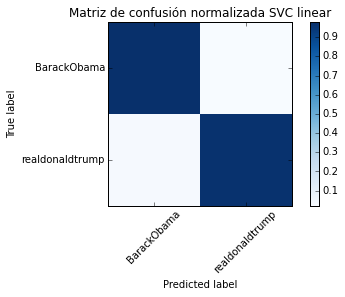

************------ SVC rbf ------************
Precisión:  0.98125
Matriz de confusión sin normalización
[[551  10]
 [ 11 548]]
Matriz de confusión normalizada 
[[ 0.98  0.02]
 [ 0.02  0.98]]


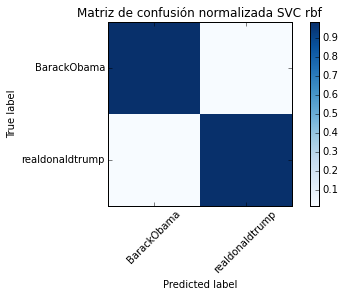

************------ SVC poly ------************
Precisión:  0.499107142857
Matriz de confusión sin normalización
[[  0 561]
 [  0 559]]
Matriz de confusión normalizada 
[[ 0.  1.]
 [ 0.  1.]]


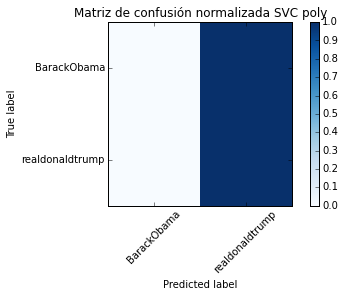

In [99]:
clasificacion(mCV_linear, StrKernel = 'SVC linear')
clasificacion(mCV_rbf, StrKernel = 'SVC rbf')
clasificacion(mCV_poly, StrKernel = 'SVC poly')

En general, los modelos de clasificación: SVC linear y SVC rbf, tienen una buena precisión a la hora de predecir los tweets de *test*, para el caso de SVC poly tiene un pésimo *accuracy* dado que, el *"modelo"* de hechar una moneda al aire lo haría mejor. Seguramente esto podría mejorar si se eligieran otros hiperparametros por medio de validación cruzada por ejemplo *degree*.

###Análisis básico de sentimientos
Una forma sencialla de hacer análisis básico de sentimientos es establecer las palabras negativas y positivas en diccionarios individuales, entonces, a partir de los tokens del tweet, cada vez que un token aparece en la lista positiva, se agrega un punto y cada vez que vea un token que aparece en la lista negativa, se deduzca un punto. El número de puntos (posiblemente normalizado por el número de palabras) indicaría el sentimiento del tweet. Finalmente, se hace el conteo final de número de tweets positivos y negativos, evidentemente habrá tweets neutrales y tambien presentan gráficamente. Lo bueno de este enfoque es que es simple. Sin embargo, debido a que se está utilizando una sola palabra, no se está considerando el contexto en que se utilizan estas palabras.

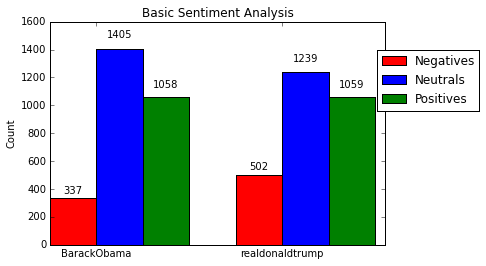

In [89]:
from collections import Counter
def readwords( filename ):
    f = open(filename)
    words = [ line.rstrip() for line in f.readlines()]
    return words
positive = readwords('positive-words.txt')
negative = readwords('negative-words.txt')
def polarity(tweet):
    tokens = tknzr.tokenize(tweet)
    count = Counter(tokens)
    pos = 0
    neg = 0
    points = 0
    for key, val in count.items():
        key = key.rstrip('.,?!\n') # removing possible punctuation signs
        if key in positive:
            pos += val
        if key in negative:
            neg += val
    points = pos - neg
    if points > 0:
        return '+'
    elif points < 0:
        return '-'
    return '0'

keys_tar = ['t1','t2']
first = True
for key in keys_tar:
    target = targets[key]
    target['polarity'] = []
    for tweet in target['tweetsText']:
        target['polarity'].append(polarity(tweet))
#Tabla de frecuencias por persona
hT1 = Counter(targets['t1']['polarity'])
#Tabla de frecuencias por persona
hT2 = Counter(targets['t2']['polarity'])
positives = [hT1['+'],hT2['+']]
negatives = [hT1['-'],hT2['-']]
neutrals = [hT1['0'],hT2['0']]
N = 2
ind = np.arange(N)  # the x locations for the groups
width = 0.25       # the width of the bars
fig, ax = plt.subplots()

rects1 = ax.bar(ind, negatives, width, color='r')
rects2 = ax.bar(ind + width, neutrals, width, color='b')
rects3 = ax.bar(ind + width + width, positives, width, color='g')

ax.set_ylabel('Count')
ax.set_title('Basic Sentiment Analysis')
ax.set_xticks(ind + width)
ax.set_xticklabels((targets['t1']["id"], targets['t2']["id"]))

ax.legend((rects1[0], rects2[0],rects3[0]), ('Negatives', 'Neutrals','Positives'),bbox_to_anchor=(1.3,0.9))
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., 1.05*height,
                '%d' % int(height),
                ha='center', va='bottom')
autolabel(rects1)
autolabel(rects2)
autolabel(rects3)
plt.show()



##Ejemplo 2200 Hillary Clinton vs Donal Trump

La siguiente ejecución, es una comparación de 2200 tweets de dos figuras en camapaña politica en USA para las elecciones 2016. genera y compara modelos de clasificación también compara la polaridad de tweets de ambos políticos. Nuevamente, tanto los modelos como los tweets fueron guardados en disco y se cargan para presentación en caso de existir. Tambien se podría hacer una nueva solicitud de otros personajes y se ejecutaría sin problema.  

*Nota* A diferencia del primer ejemplo donde se entrenaron a los modelos con un rango mas amplio de valores para el parámetro de regularización *C* aqui se redujo el rango para ahorrar tiempo de computo. Especificamente, este fue el rango seleccionado.  
*array([ 0.001,  0.005,  0.01,  0.05,  0.09,  0.1,  0.5,  0.7,  0.9,  1.0, ])*

Reutilizar: hillaryclinton2200.pickle
Reutilizar: realdonaldtrump2200.pickle
yTrain (3520,)   yTest (880,)
Descomprimir: bestModels2200.zip
Reutilizar: bestModels2200.pickle
Best hyperparameters svm.SVC(kernel='linear'):  {'C': 0.90000000000000002}
Best hyperparameters svm.SVC(kernel='rbf', gamma=0.7):  {'C': 0.90000000000000002}
Best hyperparameters svm.SVC(kernel='poly',degree=3):  {'C': 0.001}
************------ SVC linear ------************
Precisión: 

C:\Users\adane_000\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:993: RuntimeWarning: divide by zero encountered in true_divide
  idf = np.log(float(n_samples) / df) + 1.0
C:\Users\adane_000\Anaconda3\lib\site-packages\matplotlib\collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


 0.921590909091
Matriz de confusión sin normalización
[[421  31]
 [ 38 390]]
Matriz de confusión normalizada 
[[ 0.93  0.07]
 [ 0.09  0.91]]


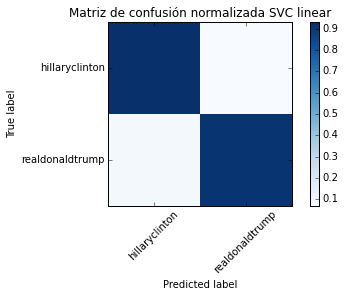

************------ SVC rbf ------************
Precisión:  0.935227272727
Matriz de confusión sin normalización
[[429  23]
 [ 34 394]]
Matriz de confusión normalizada 
[[ 0.95  0.05]
 [ 0.08  0.92]]


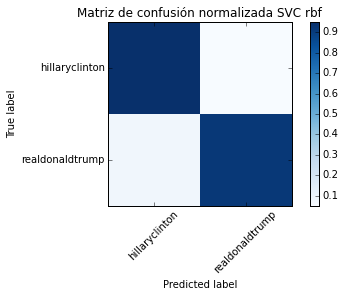

************------ SVC poly ------************
Precisión:  0.486363636364
Matriz de confusión sin normalización
[[  0 452]
 [  0 428]]
Matriz de confusión normalizada 
[[ 0.  1.]
 [ 0.  1.]]


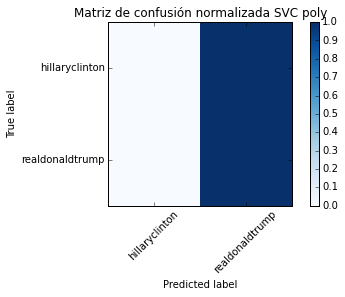

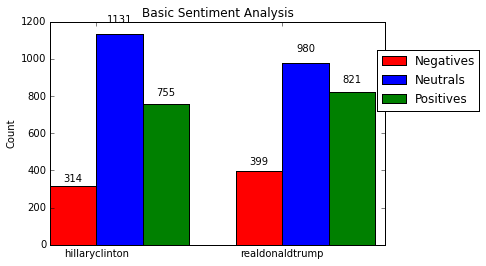

In [100]:
run P4ClaTweJAET.py -t1 hillaryclinton -t2 realdonaldtrump -t 2200

##Conclusiones
Como lo mencioné anteriormente, las aplicaciones son infinitas cuando se analiza la información disponible en twitter, con los casos presentados en esta demostración, para el tema de clasificación se obtiene una buena precisión, dado que, al estar en campaña el señor Trump, los hashtag que apoyan su campaña, son muy determinante dado su TfIdf. Asi mismo, para el tema de análisis básico de sentimientos BarackObama utiliza un lenguaje más conservador y *apropiado* al tener una polaridad de tweet con tendencia a los positivos, en cambio, el Sr Trump al estar en campaña es más suceptible a confrontaciones y por ende a tener una polaridad negativa, por otra parte la candidata Hillary Clinton tiene un comportamiento más neutral con respecto el análisis de sentimiento básico planteado.